## Implementation of methods used by Eicken, H. (1993) for Ice thin sections in Petrographical thin sections (Troctolite, XPL, from the MacQuarie  University Database)


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2 
import ipywidgets as wd

### Original Images

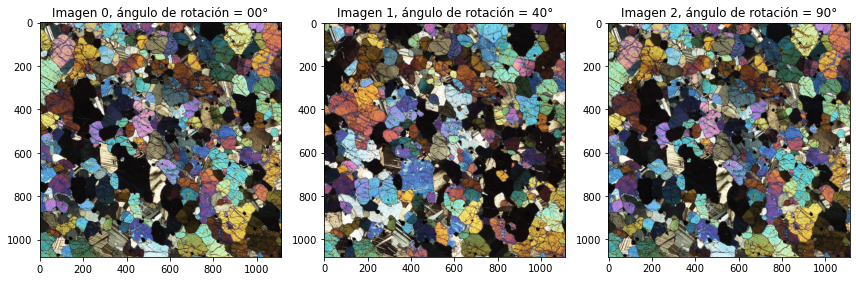

In [2]:
img = cv2.imread('XPL00.jpg',1)
img1 = cv2.imread("XPL40.jpg",1)
img2 = cv2.imread('XPL90.jpg',1)
imgsorg = [img,img1,img2]
angulos = ["00", "40", "90"]
def graphImgsColor(imgs):
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(12,6))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i])
        ax.set_title(f"Imagen {i}, ángulo de rotación = {angulos[i]}°")
    fig.tight_layout()
graphImgsColor(imgsorg)

### Gray Histograms

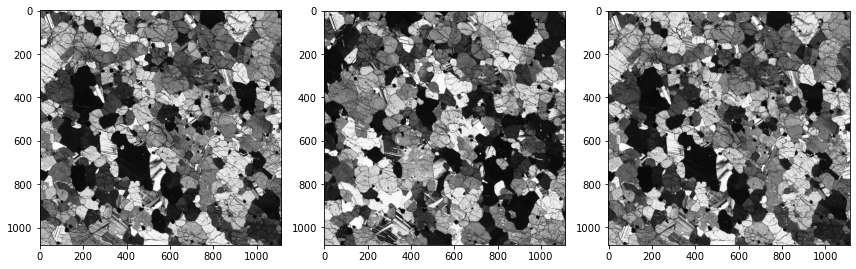

In [3]:
img = cv2.imread('XPL00.jpg',0)
img1 = cv2.imread("XPL40.jpg", 0)
img2 = cv2.imread('XPL90.jpg',0)
imgs = [img,img1,img2]

def graphImgs(imgs, title=None, cmap="Greys_r", figsize=(12,6)):
    """ imgs ->  a list of images
        title ->  a list of strings        
        returns mpl subplots
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i], cmap=cmap)
        if title is not None:
            try:
                ax.set_title(title[i])
            except:
                pass
    fig.tight_layout()

graphImgs(imgs)

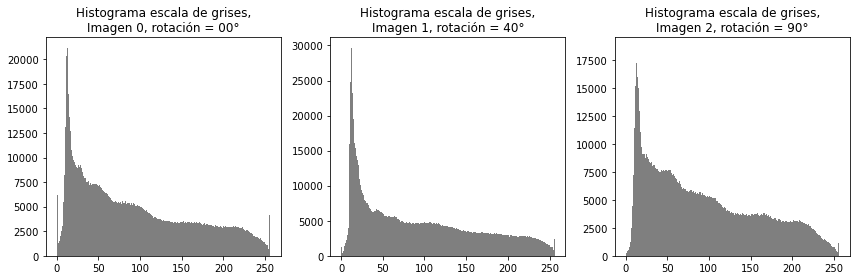

In [4]:
def plotGrayHist(imgs):
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(12,4))
    for i, ax in enumerate(axes):
        ax.hist(imgs[i].ravel(),256,[0,256], color="k", alpha=0.5)
        ax.set_title(f"Histograma escala de grises,\nImagen {i}, rotación = {angulos[i]}°")
    fig.tight_layout()    
plotGrayHist(imgs)

#### Image Enhancing median filter

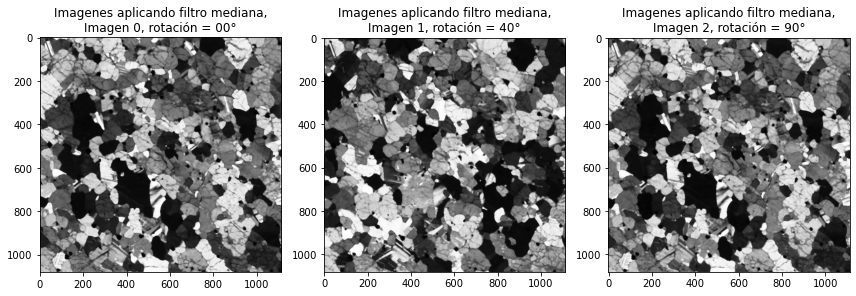

In [5]:
def medianImgs(imgs):
    global imgsMedian 
    imgsMedian =[]
    fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(12,4))
    for i, ax in enumerate(axes):
        imgMed = cv2.medianBlur(imgs[i], 7)
        ax.imshow(imgMed,  cmap="Greys_r")
        ax.set_title(f"Imagenes aplicando filtro mediana,\nImagen {i}, rotación = {angulos[i]}°")
        imgsMedian.append(imgMed)
    fig.tight_layout()    

medianImgs(imgs)

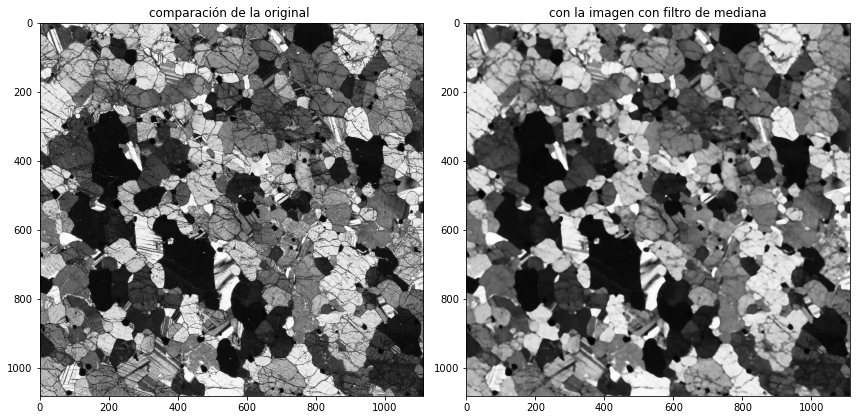

In [6]:
compare_original_median = [imgs[0], imgsMedian[0]]
graphImgs(compare_original_median, ["comparación de la original ","con la imagen con filtro de mediana"])

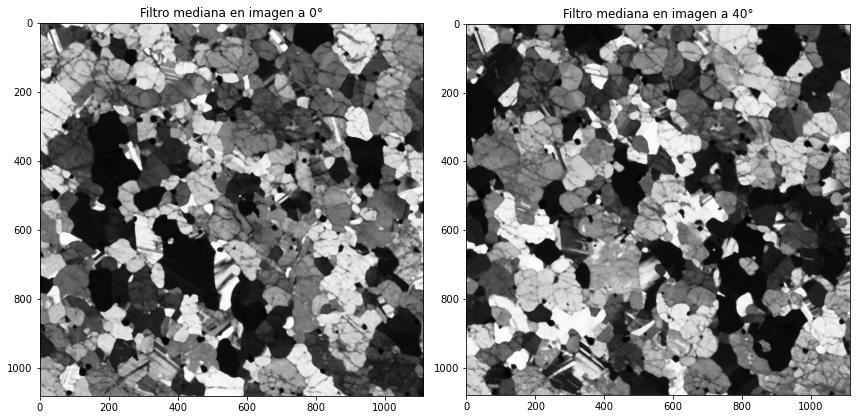

In [7]:
compare = [imgsMedian[0], imgsMedian[1]]
graphImgs(compare, ["Filtro mediana en imagen a 0°", "Filtro mediana en imagen a 40°"])

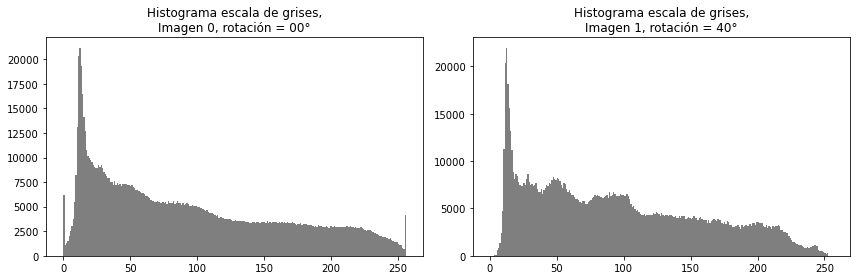

In [8]:
plotGrayHist(compare_original_median)

### Procesos Morfológicos: Erosión y dilatación (opening)
Operations of sequentially dilating and eroding an image

In [9]:

erosionDilationImgs5 = []
for i in imgsMedian:
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(i, kernel, iterations=10)
    dilated = cv2.dilate(eroded, kernel, iterations=10)
    erosionDilationImgs5.append(dilated)


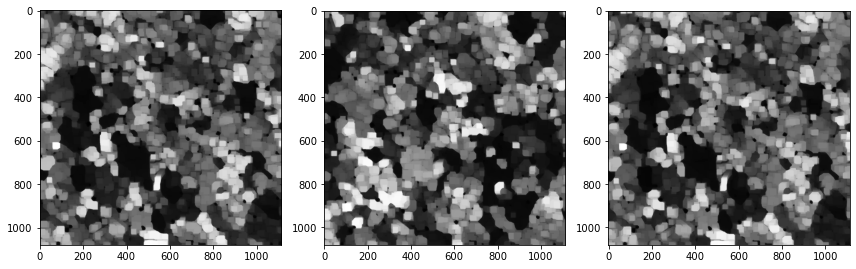

In [10]:
graphImgs(erosionDilationImgs5)

### Filtro paso bajo

In [11]:
pasoBajo = []

for i in erosionDilationImgs5:
    blur = cv2.GaussianBlur(i,(5,5),0)
    pasoBajo.append(blur)

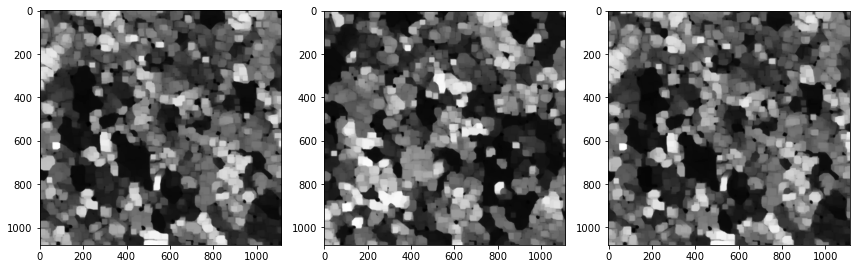

In [12]:
graphImgs((pasoBajo))

### Detección de bordes (Sobel)

In [15]:
def applySobelY(img, ksize):
    sobely = cv2.Sobel(img,cv2.CV_16S, 0, 1,ksize, scale=1, delta=0, borderType =cv2.BORDER_DEFAULT)
    absGradY = cv2.convertScaleAbs(sobely)
    return absGradY

def applySobelX(img, ksize): 
    sobelx = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize,scale=1, delta=0, borderType =cv2.BORDER_DEFAULT)
    absGradX = cv2.convertScaleAbs(sobelx)
    return absGradX

def applySobel(img, ksize):
    absGrady = applySobelY(img, ksize)
    absGradx = applySobelX(img, ksize)
    grad = cv2.addWeighted(absGradx, 0.5, absGrady, 0.5, 0)
    return grad

sobelImgs = []

for i in compare_original_median:
    i = i[:,:1111]
    sobel = applySobel(i, ksize=10)
    sobelImgs.append(sobel)
    


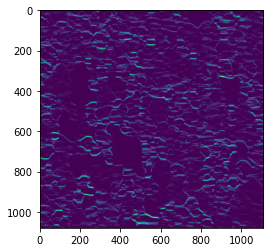

In [16]:
plt.imshow(applySobelY(pasoBajo[0],5))

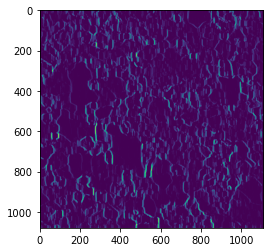

In [17]:
plt.imshow(applySobelX(pasoBajo[0],5))

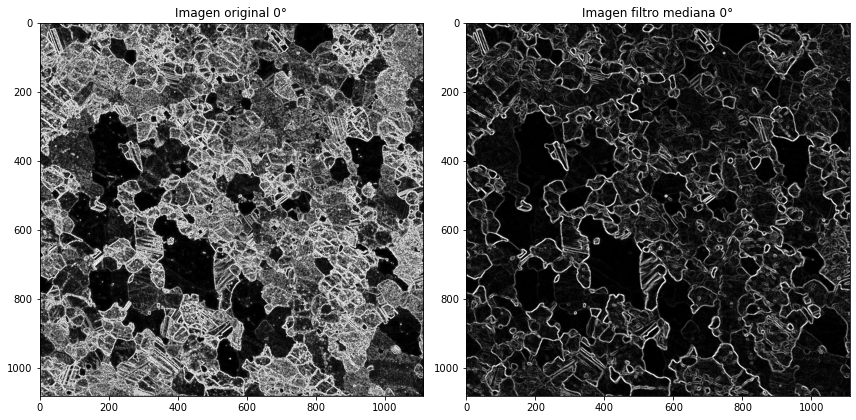

In [18]:
graphImgs(sobelImgs, ["Imagen original 0°", "Imagen filtro mediana 0°"])

In [19]:
sobelPasoBajo = []
for i in pasoBajo:
    j = i[:,:1111]
    sobelBajo = applySobel(j, ksize=5)
    sobelPasoBajo.append(sobelBajo)
    

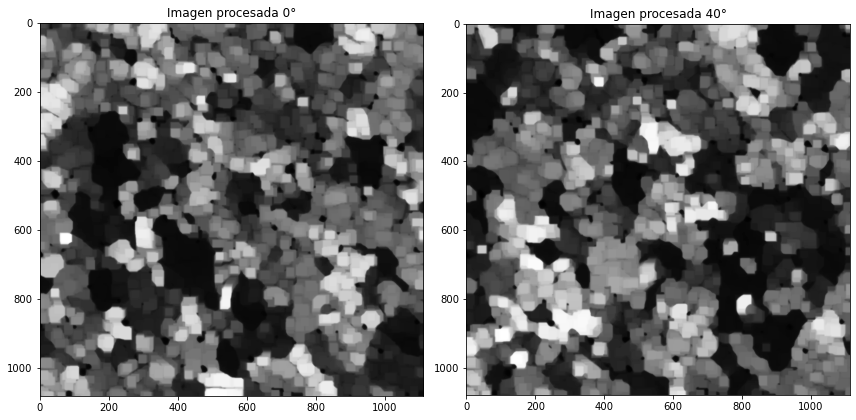

In [20]:
graphImgs(pasoBajo[:2], ["Imagen procesada 0°", "Imagen procesada 40°"])

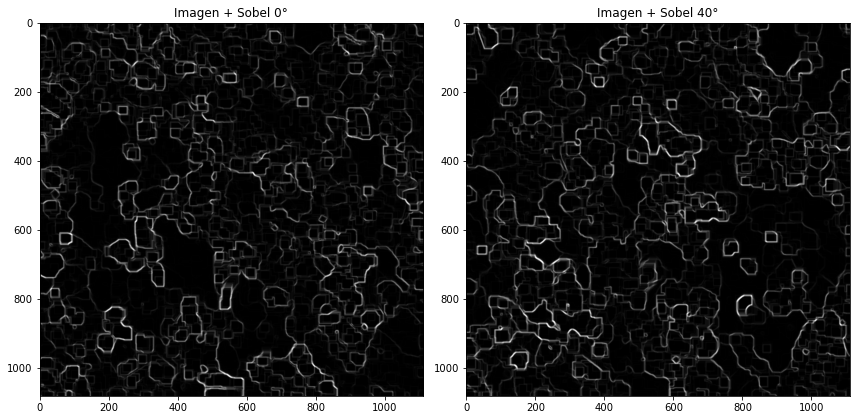

In [21]:
graphImgs(sobelPasoBajo[:2], ["Imagen + Sobel 0°", "Imagen + Sobel 40°"])

### Adición imagenes

#### Sumando

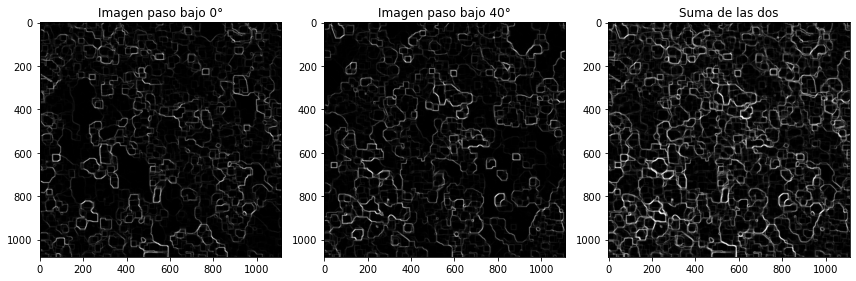

In [43]:
img1 = sobelPasoBajo[0]
img2 = sobelPasoBajo[1]
dstAdd = cv2.add(img1, img2)
graphImgs([img1, img2, dstAdd], title=["Imagen paso bajo 0°", "Imagen paso bajo 40°", "Suma de las dos"], cmap="Greys_r")

#### Operación union de open-cv "Blending"

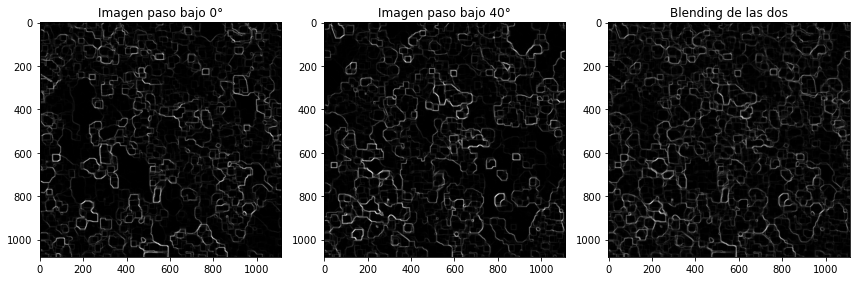

In [23]:
img1 = sobelPasoBajo[0]
img2 = sobelPasoBajo[1]
dstBlend = cv2.addWeighted(img1,0.5,img2,0.5,0)
graphImgs([img1, img2, dstBlend], title=["Imagen paso bajo 0°", "Imagen paso bajo 40°", "Blending de las dos"], cmap="Greys_r")

### Binarización

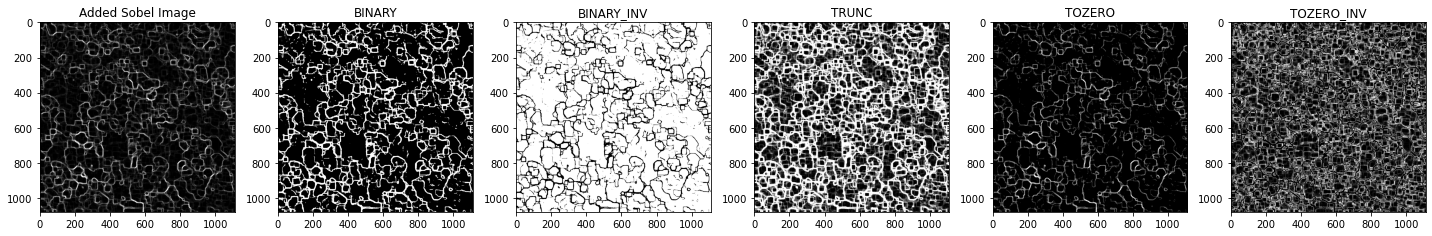

In [79]:
desde = 40


ret,thresh1 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_TOZERO_INV)
titles = ['Added Sobel Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [dstAdd, thresh1, thresh2, thresh3, thresh4, thresh5]
graphImgs(images, titles, figsize=(20,5))

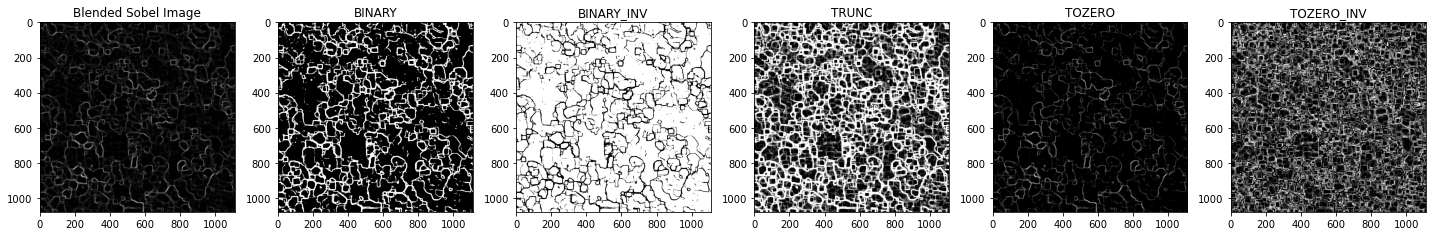

In [25]:
desde = 20


ret,thresh1 = cv2.threshold(dstBlend,desde,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(dstBlend,desde,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(dstBlend,desde,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(dstBlend,desde,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(dstBlend,desde,255,cv2.THRESH_TOZERO_INV)
titles = ['Blended Sobel Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [dstBlend, thresh1, thresh2, thresh3, thresh4, thresh5]
graphImgs(images, titles, figsize=(20,5))

### Exploración interactiva de la binarización con las imagenes Sobel adicionadas

In [26]:
@wd.interact(desde=(0,255,1))

def actualice(desde=40):
    ret,thresh1 = cv2.threshold(dstAdd,desde,255,cv2.THRESH_BINARY)    
    return graphImgs([dstAdd, thresh1], ["Imagen Sobel Adicionada", f"Binarizada {desde}-255"]) # Se recomienda dejar el valor B entre 2 y 3 veces mayor que A



interactive(children=(IntSlider(value=40, description='desde', max=255), Output()), _dom_classes=('widget-inte…

In [110]:
import copy
dstAddCopy = dstAdd.copy()
ret,binary = cv2.threshold(dstAddCopy,40,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(dstAddCopy, contours, -1,(0, 0,0),1)


# im = cv2.imread('XPL00.jpg')
# imCopy = im.copy()
# imgray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# ret,thresh = cv2.threshold(imgray,127,255,0)
# contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(imCopy,contours,-1,(0,255,0))
# graphImgs([binary, binaryCopy], ["Imagen Binarizada", "Función Contornos"])
cv2.imshow('thresh1',dstAddCopy)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [78]:
import numpy as np
import cv2

im = cv2.imread('XPL00.jpg')
imCopy = im.copy()
imgray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imCopy,contours,-1,(0,255,0))
cv2.imshow('draw contours',imCopy)
cv2.waitKey(0)

-1